In [53]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
import json
from utils import *
import math
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from helper_code.full_extraction_pipeline import is_valid_color, get_reconstructed_plot
from roboflow import Roboflow
import supervision as sv
import cv2

In [54]:
sam = sam_model_registry["default"](checkpoint="../../../Downloads/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

In [55]:
rf = Roboflow(ROBOFLOW_API_KEY)
project = rf.workspace().project("legend_classified")
model = project.version(3).model

loading Roboflow workspace...
loading Roboflow project...


In [56]:
image_num = 27

In [60]:
from helper_code.mask_detection import show_mask

def get_bounding_box(main_mask, new_image):

    boundingBox = {
        "topLeft": None,
        "bottomRight": [0,0],
    }

    topLeft = False

    for i in range(len(new_image)):
        for j in range(len(new_image[0])):
            if main_mask[i][j]:
                if not topLeft:
                    boundingBox["topLeft"] = [j, i]
                    topLeft = True
                boundingBox["topLeft"] = [min(boundingBox["topLeft"][0], j), min(boundingBox["topLeft"][1], i)]
                boundingBox["bottomRight"] = [max(boundingBox["bottomRight"][0], j), max(boundingBox["bottomRight"][1], i)]
    
    return boundingBox

def get_main_mask(masks, scores, image=None):
    sorted_masks = sorted(zip(masks, scores), key=lambda x: x[1], reverse=True)
    main_mask = sorted_masks[0][0]
    main_mask_score = sorted_masks[0][1]
    if image is not None:
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(main_mask, plt.gca())
    return main_mask, main_mask_score 

def keep_largest_component(mask):
    """
    Keep only the largest connected component in the mask.

    Parameters:
    mask (numpy.ndarray): The binary mask.

    Returns:
    numpy.ndarray: The mask with only the largest connected component.
    """
    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # If there's no component (other than background), return the same mask
    if num_labels <= 1:
        return mask

    # Find the largest component, ignoring the background (label 0)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    
    # Create a mask of the largest component
    largest_component = (labels == largest_label).astype(np.uint8)

    return largest_component

def clean_mask_edges_and_convert_back(mask, kernel_size=3):
    # Convert the boolean mask to uint8 format
    mask_uint8 = (mask * 255).astype(np.uint8)

    # Create the kernel for morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Perform opening to remove noise and then closing to close small holes
    mask_cleaned = cv2.morphologyEx(mask_uint8, cv2.MORPH_OPEN, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

    # Keep only the largest connected component
    largest_component = keep_largest_component(mask_cleaned)

    return largest_component

def do_analysis(image_number, predictor):
    image_name = '../plot_images/'+str(image_number)+'.png'
    img = cv2.imread(image_name)

    # Adjust contrast
    # Here, al`pha is the contrast control (1.0-3.0)
    # beta is the brightness control (0-100)
    alpha = 2  # Contrast control (1.0-3.0)

    image = cv2.convertScaleAbs(img, alpha=alpha)

    height, width = image.shape[:2]
    input_point = np.array([[width // 2 - 50, height // 2 - 50], [width // 2 - 50, height // 2 + 50], [width // 2 + 50, height // 2 - 50], [width // 2 + 50, height // 2 + 50]])
    input_label = np.array([1, 1, 1, 1])

    predictor.set_image(image)

    masks, scores, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )
    
    predictor.reset_image()
    
    main_mask, score = get_main_mask(masks, scores, image)
    print(f"MAIN MASK: {score}")  

    print(main_mask)


    main_mask_cleaned = clean_mask_edges_and_convert_back(main_mask)

    n_image = image.copy()
    boundingBox = get_bounding_box(main_mask_cleaned, n_image)

    plt.figure(figsize=(10,10))
    plt.imshow(n_image)
    show_mask(main_mask_cleaned, plt.gca())
    
    print(boundingBox)
    return image_name, boundingBox

In [61]:
import cv2

def draw_bounding_box(image, top_left, bottom_right, color=(0, 255, 0), thickness=2):
    """
    Draw a bounding box on an image.

    Parameters:
    image (numpy.ndarray): The image on which to draw.
    top_left (tuple): The top-left corner of the bounding box (x, y).
    bottom_right (tuple): The bottom-right corner of the bounding box (x, y).
    color (tuple): The color of the box (B, G, R).
    thickness (int): The thickness of the box lines.

    Returns:
    numpy.ndarray: The image with the bounding box drawn.
    """
    # Draw the rectangle on the image
    cv2.rectangle(image, top_left, bottom_right, color, thickness)

    return image

IMAGE NUMBER 1
MAIN MASK: 1.000955581665039
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [61, 38], 'bottomRight': [404, 313]}


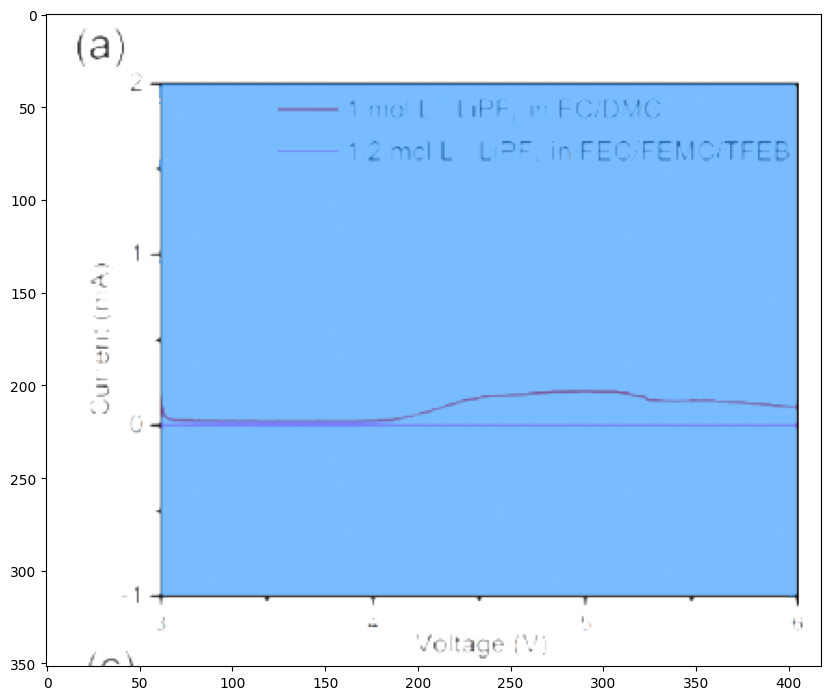

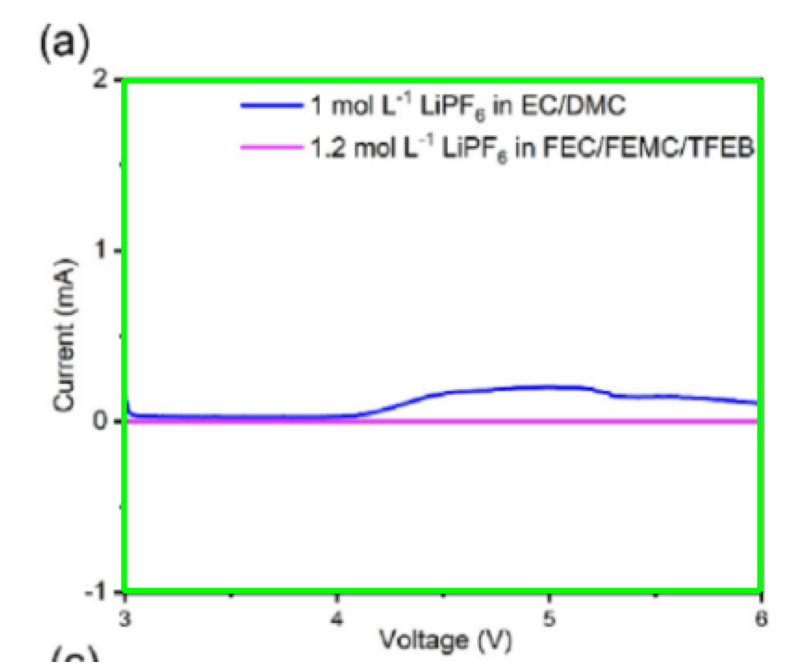

IMAGE NUMBER 2
MAIN MASK: 1.0088638067245483
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [72, 10], 'bottomRight': [413, 284]}


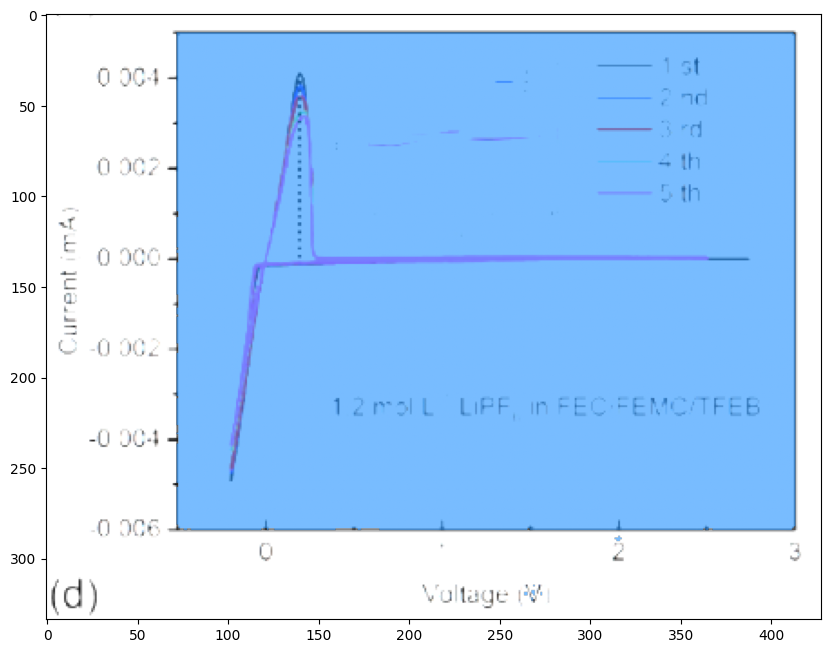

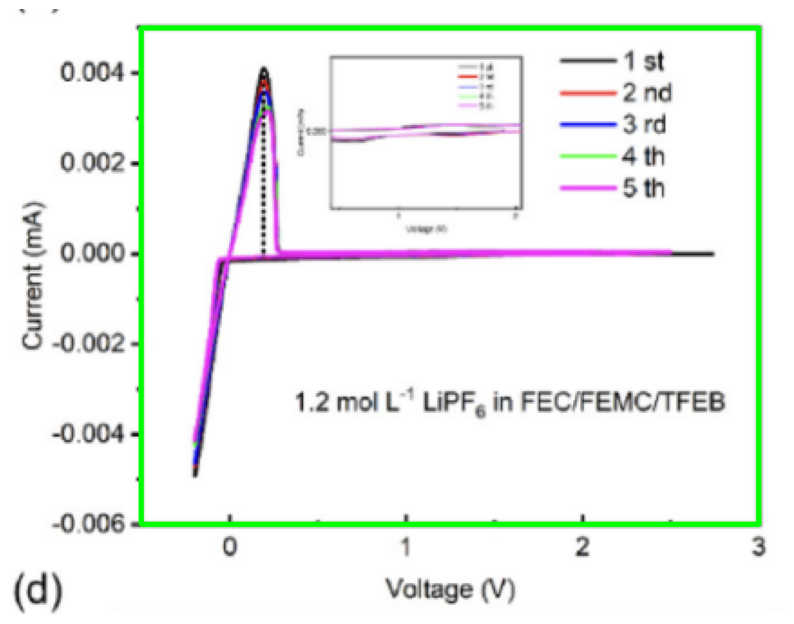

IMAGE NUMBER 3
MAIN MASK: 1.0067322254180908
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [78, 0], 'bottomRight': [422, 279]}


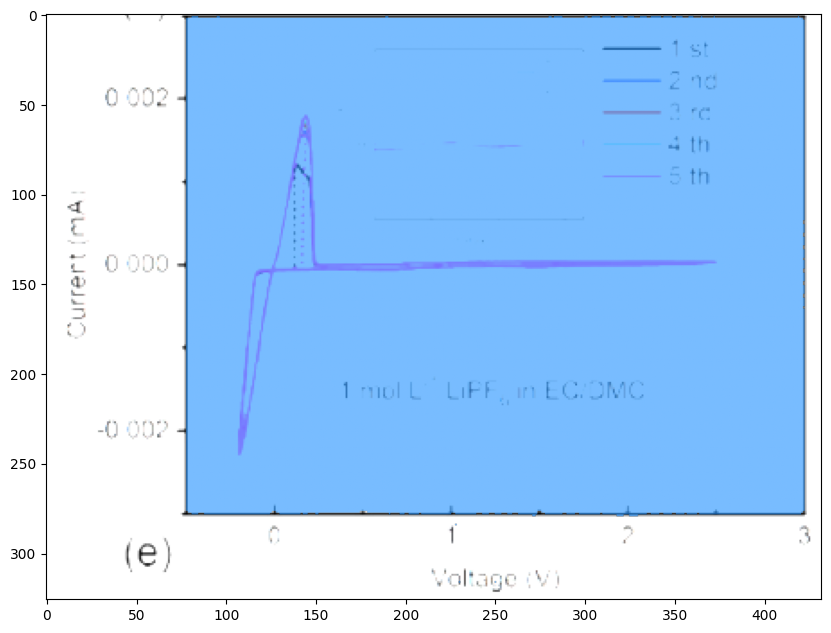

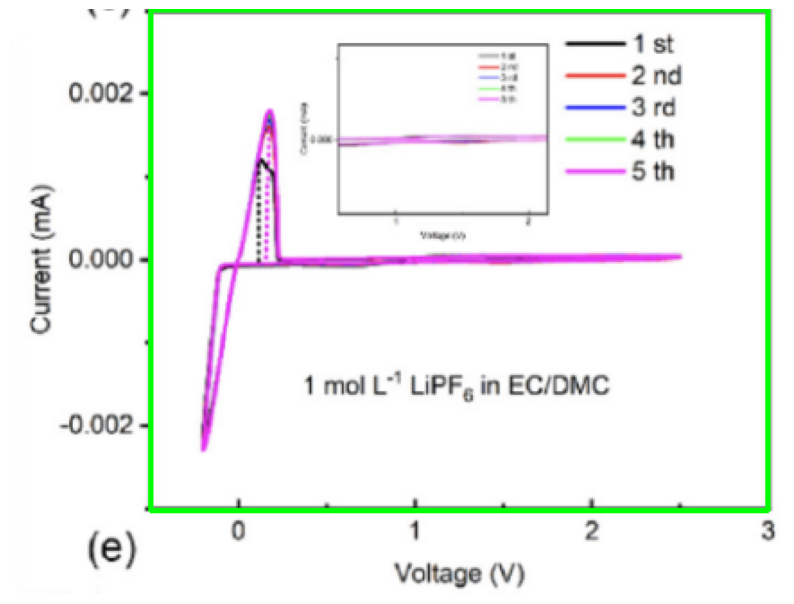

IMAGE NUMBER 4
MAIN MASK: 0.9924468994140625
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [65, 10], 'bottomRight': [418, 272]}


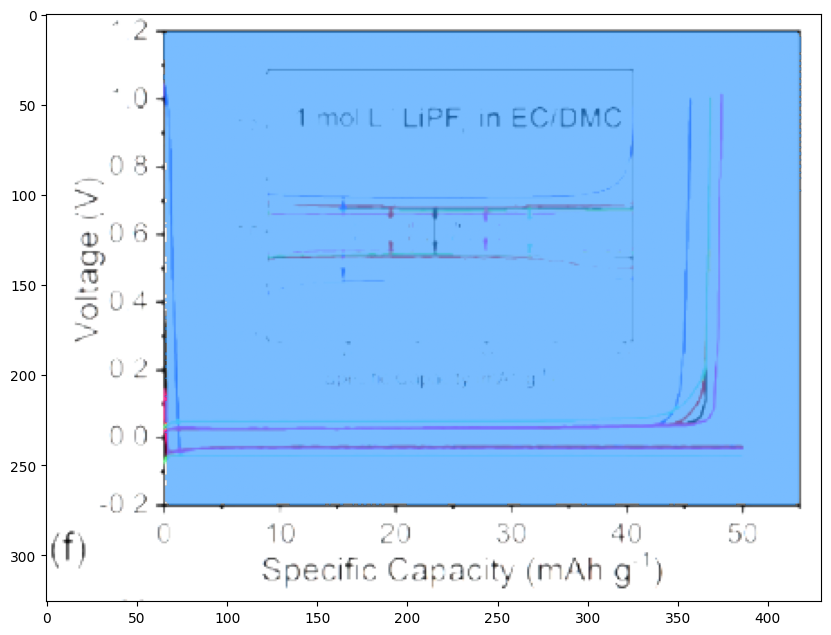

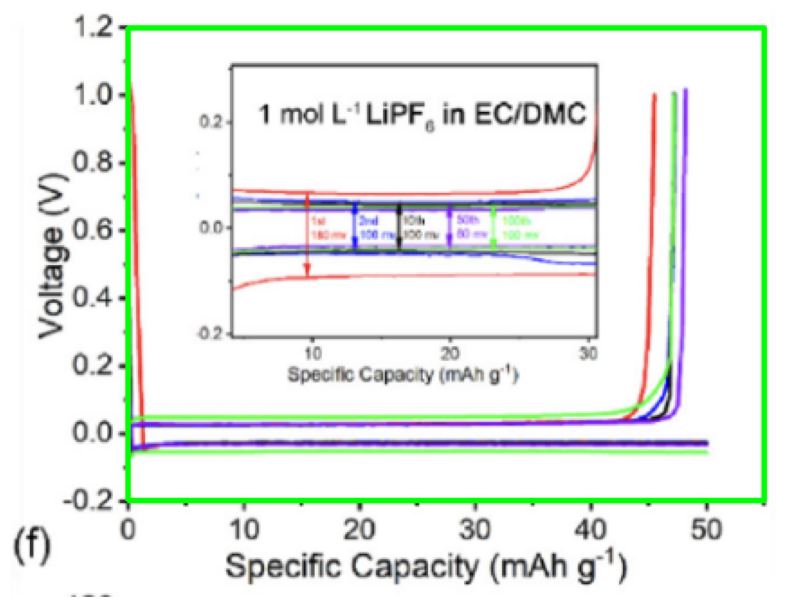

IMAGE NUMBER 5
MAIN MASK: 1.00187349319458
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [61, 11], 'bottomRight': [411, 259]}


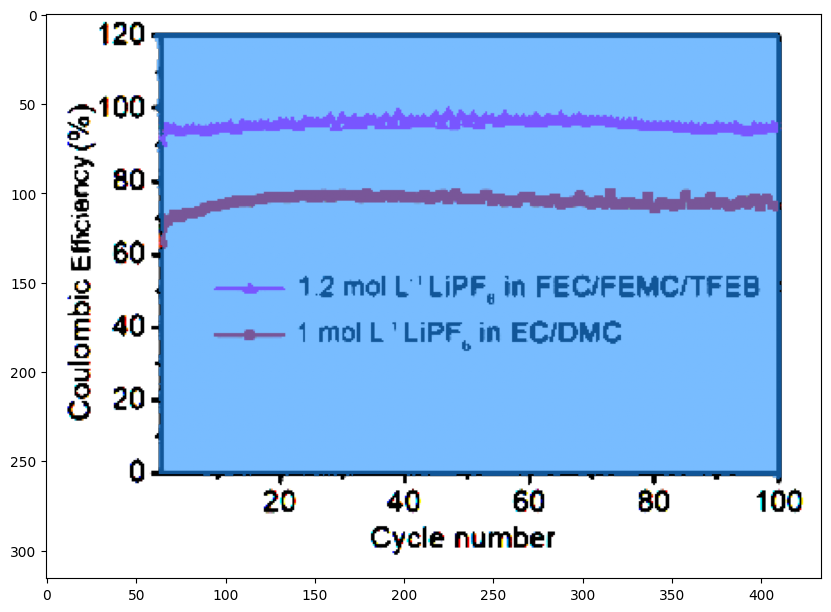

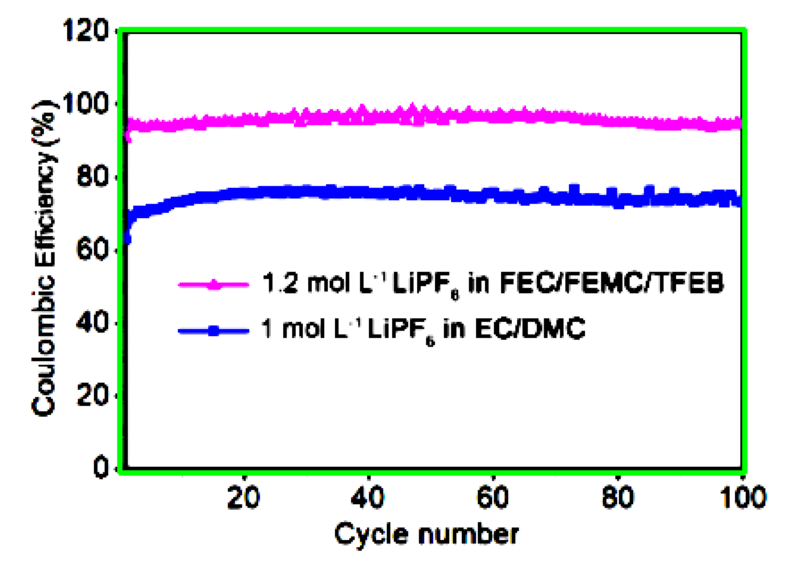

IMAGE NUMBER 6
MAIN MASK: 1.0146082639694214
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [76, 44], 'bottomRight': [387, 242]}


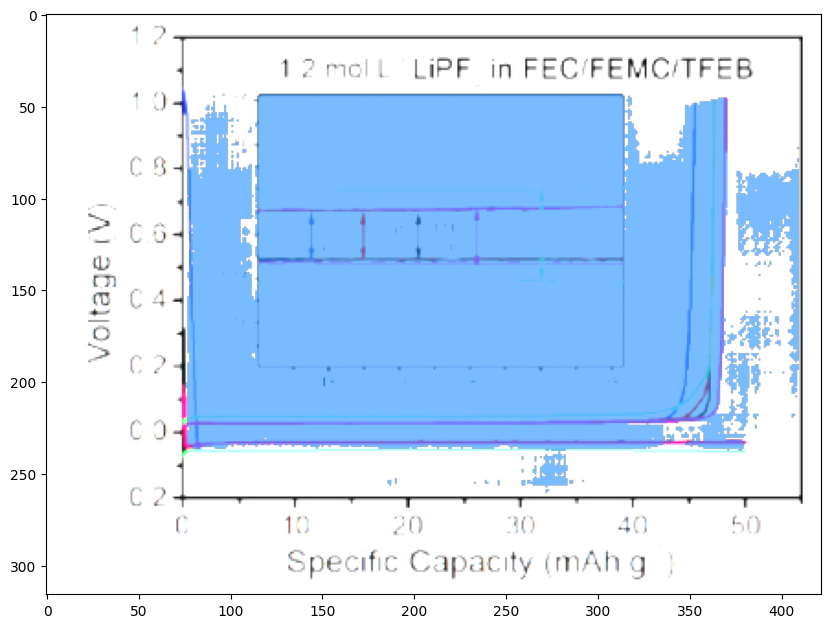

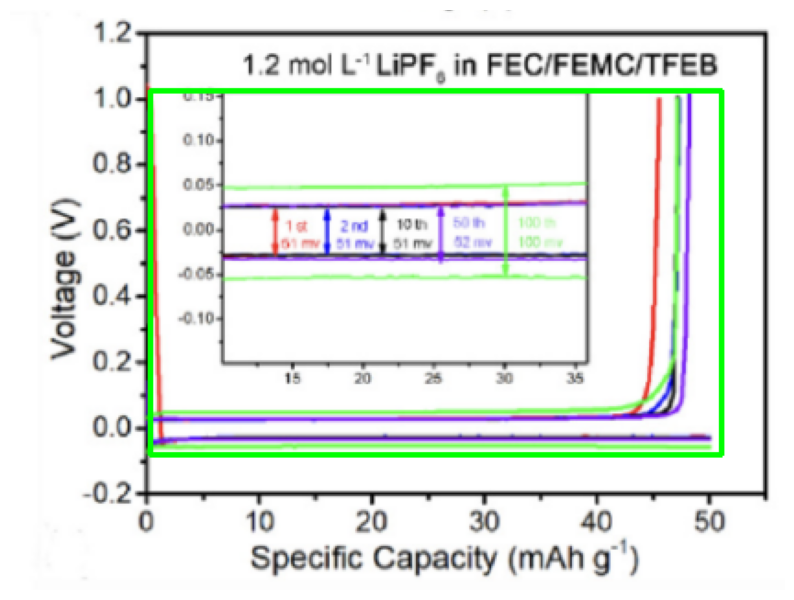

IMAGE NUMBER 7
MAIN MASK: 1.0039160251617432
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [116, 19], 'bottomRight': [802, 334]}


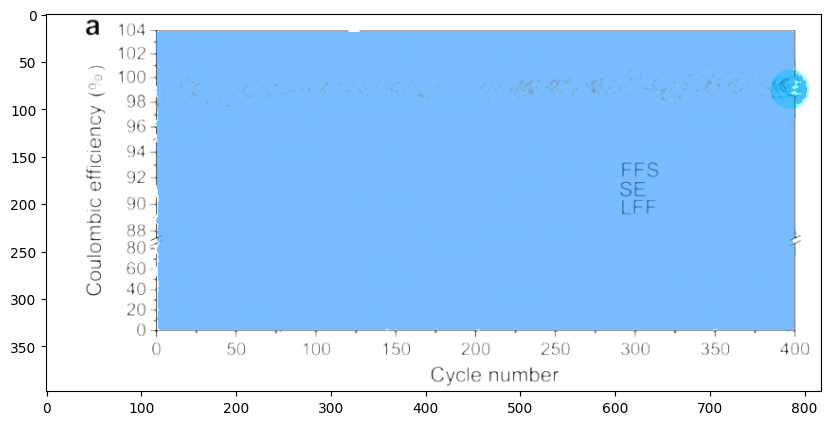

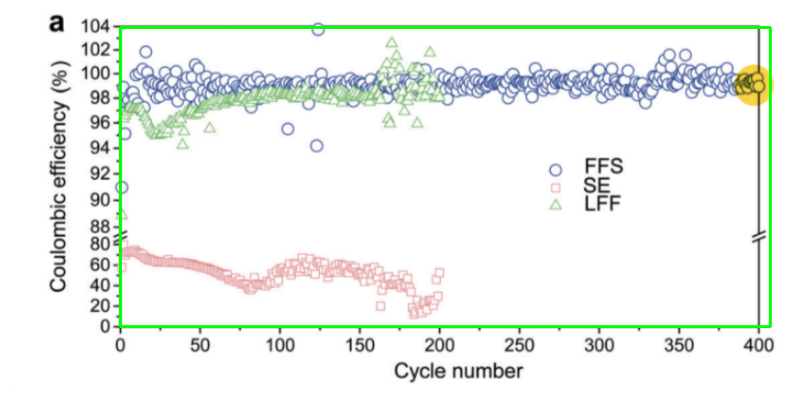

IMAGE NUMBER 8
MAIN MASK: 0.9794656038284302
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [0, 0], 'bottomRight': [499, 343]}


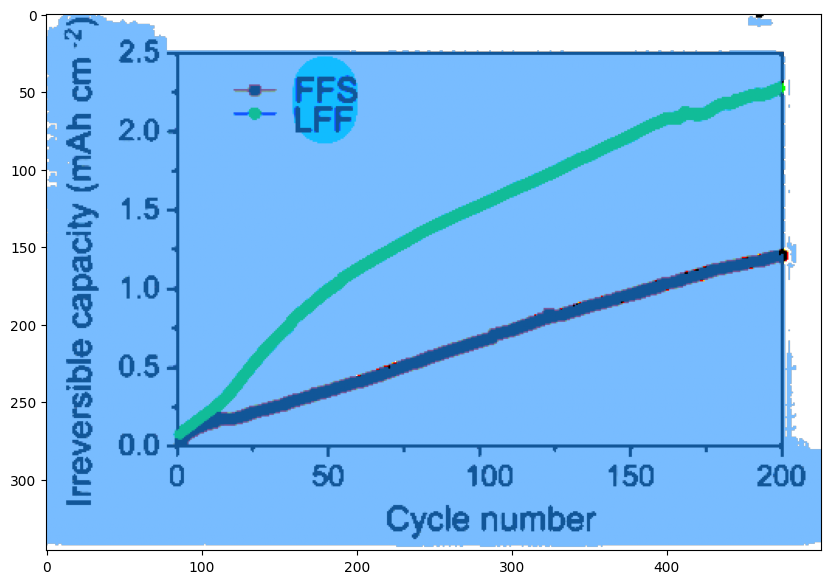

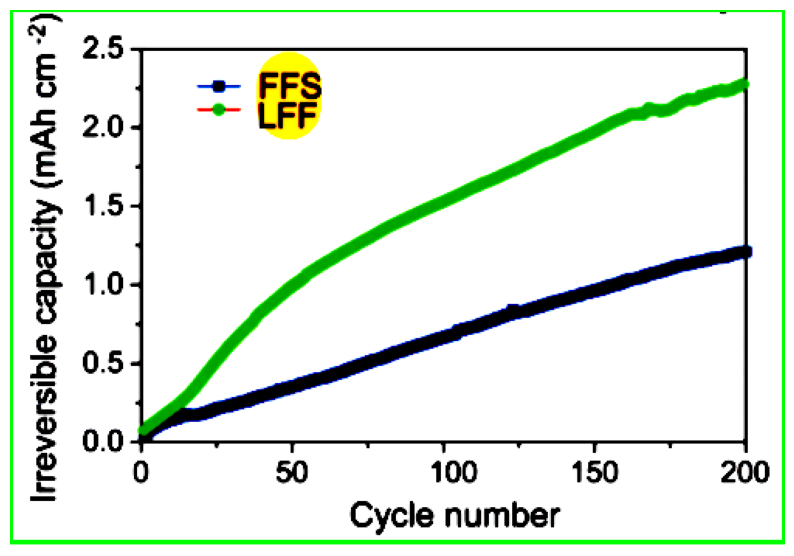

IMAGE NUMBER 9
MAIN MASK: 0.9944403171539307
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [87, 13], 'bottomRight': [451, 271]}


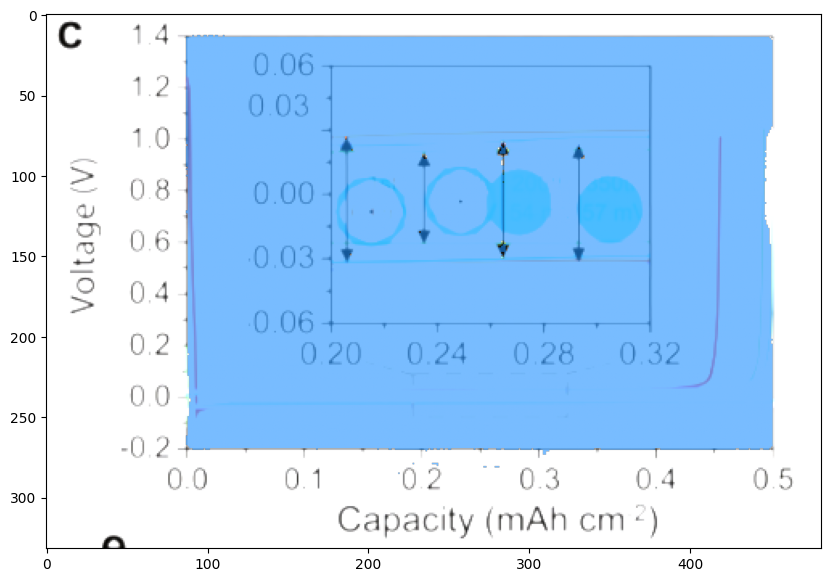

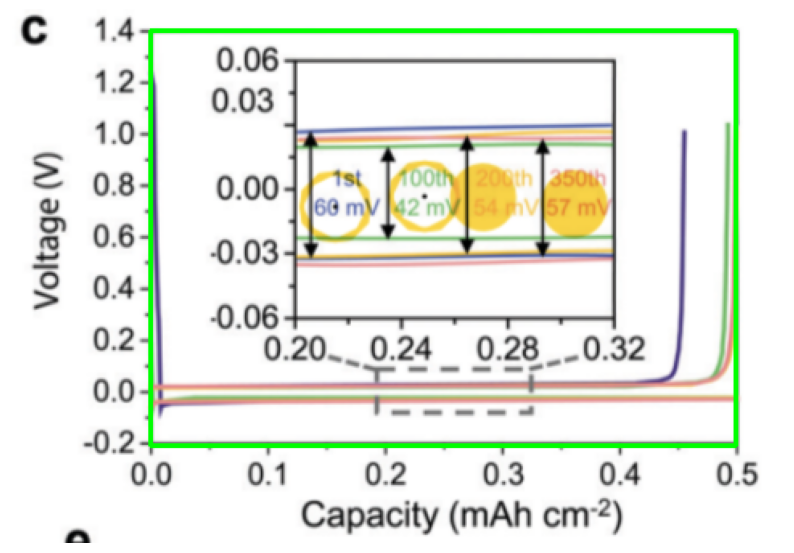

IMAGE NUMBER 10
MAIN MASK: 1.0039405822753906
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [96, 19], 'bottomRight': [479, 301]}


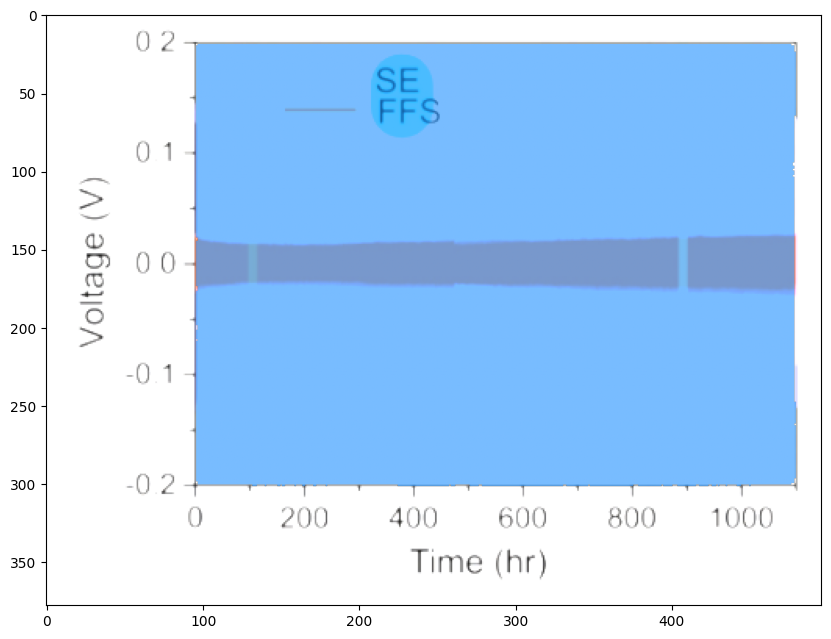

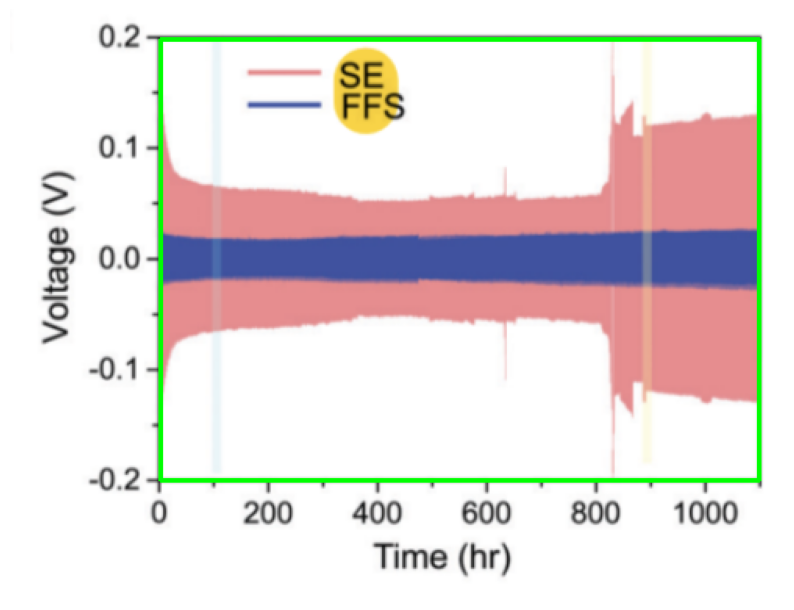

IMAGE NUMBER 11
MAIN MASK: 0.9958059787750244
[[False False False ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [0, 0], 'bottomRight': [375, 187]}


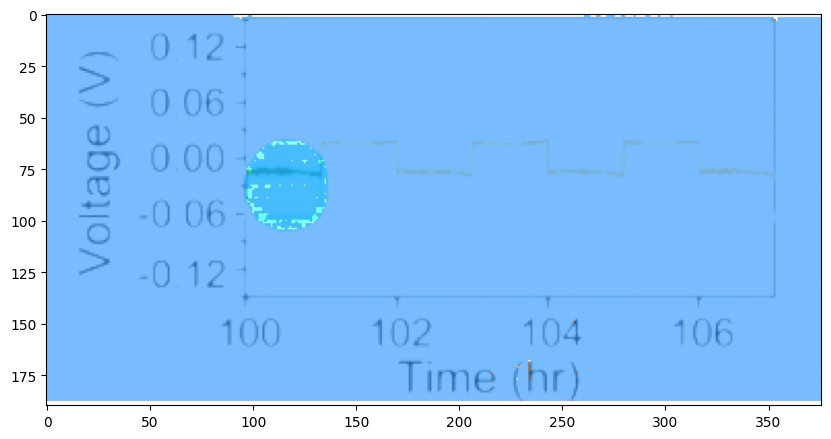

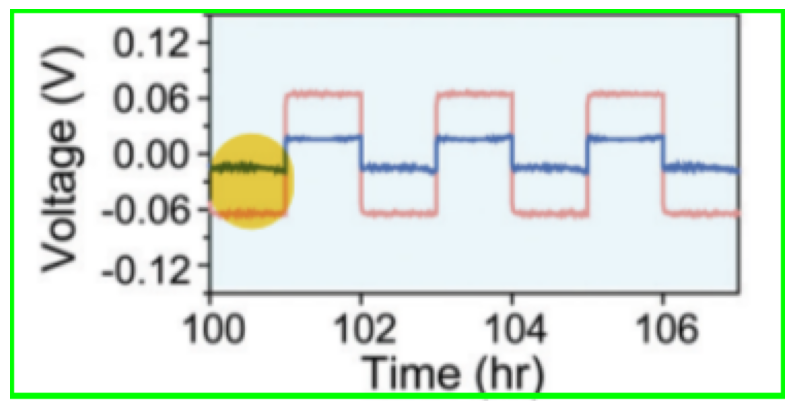

IMAGE NUMBER 12
MAIN MASK: 1.0061582326889038
[[False False False ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [False False False ... False False False]
 [False False False ... False False False]]
{'topLeft': [0, 0], 'bottomRight': [375, 207]}


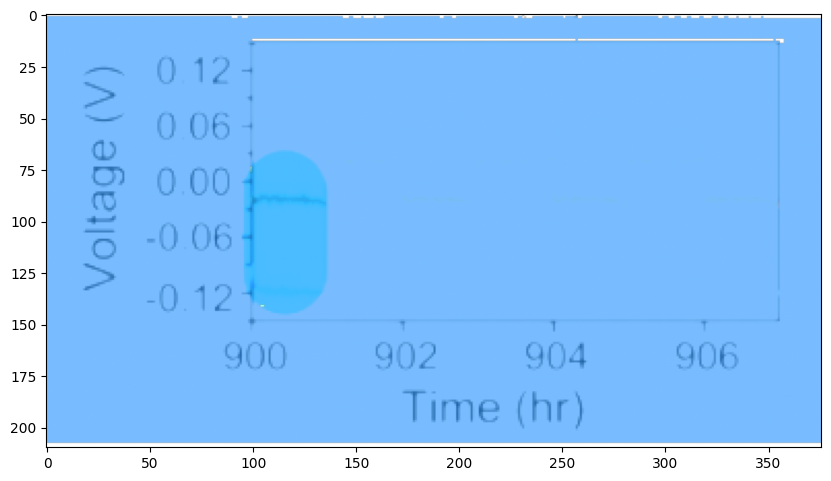

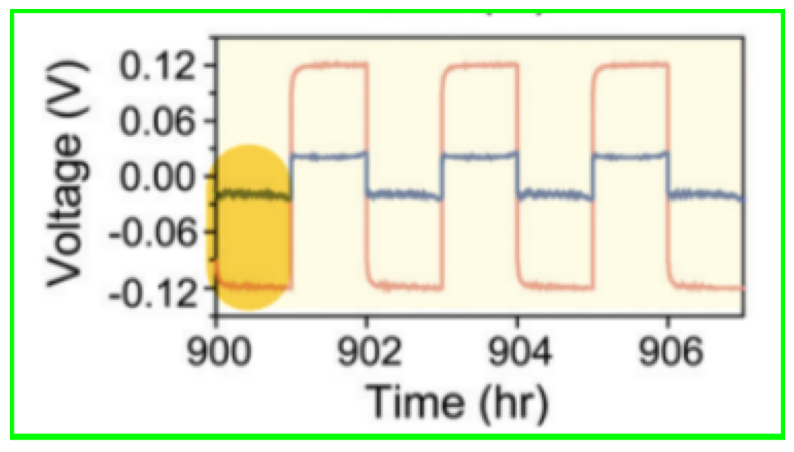

IMAGE NUMBER 13


KeyboardInterrupt: 

In [62]:
for image_num in range(1, 29):
    print("IMAGE NUMBER", image_num)
    image_name, boundingBox = do_analysis(image_num, predictor)
    if boundingBox:
        image_name = '../plot_images/'+str(image_num)+'.png'
        image = cv2.imread(image_name)
        # Draw the bounding box on the image
        image_with_box = draw_bounding_box(image.copy(), boundingBox["topLeft"], boundingBox["bottomRight"])

        # Display the image with the bounding box
        plt.imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()